# Part I: Set Up

- Import Packages

In [232]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras.utils import plot_model
from keras import backend as K
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.core import Flatten
import keras
import h5py
import os
import graphviz
import pydot
from statistics import mean
import matplotlib.pyplot as plt
from mosek.fusion import *
from keras.utils.vis_utils import plot_model

- Initialize Variables

In [233]:
seq_len = 72
shape = [seq_len, 19, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.3
epochs = 50

In [234]:

os.chdir("/Users/youssefberrada/Dropbox (MIT)/15.961 Independant Study/Data")
#os.chdir("/Users/michelcassard/Dropbox (MIT)/15.960 Independant Study/Data")
file = 'FX-5-merg.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)
close = pd.ExcelFile('close.xlsx')
df_close=np.array(close.parse(0))

# Part 2: Data

- Load Data

In [235]:
def get_stock_data(stock_name, ma=[],bollinger=[],exp_ma=[],ma_conv=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    
    """
    df = xl.parse(stock_name)
    #df.drop(['VOLUME'], 1, inplace=True)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)
     # Percentage change
    df['Pct'] = df['Adj Close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Adj Close'].rolling(window=moving).mean()
    # Bollinger   
    if bollinger != []:
        def bbands(price, length=30, numsd=2):
            """ returns average, upper band, and lower band"""
            ave = pd.stats.moments.rolling_mean(price,length)
            sd = pd.stats.moments.rolling_std(price,length)
            upband = ave + (sd*numsd)
            dnband = ave - (sd*numsd)
            return np.round(upband,3), np.round(dnband,3)
        for moving in bollinger:
            df['{}bollingerup'.format(moving)],df['{}bollingerdown'.format(moving)] = bbands(df['Adj Close'], length=moving, numsd=2)
        
    # Exponential Moving Average    
    if exp_ma != []:
        for moving in exp_ma:
            df['{}exp_ma'.format(moving)] = df['Adj Close'].ewm(min_periods=1, adjust=True,com=moving).mean()
   
    # Moving Average Convergence   
    if ma_conv!= []:
        for moving in ma_conv:
            df['{}ma_conv'.format(moving)] = df['Adj Close'].ewm(min_periods=1, adjust=True,com=moving[0]).mean()-df['Adj Close'].ewm(min_periods=1, adjust=True,com=moving[1]).mean()
    
    
    
    df.dropna(inplace=True)
    
  
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['Adj Close']
    df.drop(labels=['Adj Close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

- Visualize the data

In [236]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

- Training/Test Set

In [237]:
def load_data(stock,normalize,seq_len,split,ma=[],bollinger=[],exp_ma=[],ma_conv=[]):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    sequence_length = seq_len+1
    result_train = []
    result_test= []
    row = round(split * stock.shape[0])
    df_train=stock[0:row].copy()
    print ("Amount of training data = {}".format(df_train.shape[0]))
    df_test=stock[row:len(stock)].copy()
    print ("Amount of testing data = {}".format(df_test.shape[0]))


    if normalize:
        #Training
        min_max_scaler = preprocessing.MinMaxScaler()
        min_max_scaler.fit(df_train['Adj Close'].values.reshape(-1,1))
        df_train['Open'] = min_max_scaler.transform(df_train['Open'].values.reshape(-1,1))
        df_train['High'] = min_max_scaler.transform(df_train['High'].values.reshape(-1,1))
        df_train['Low'] = min_max_scaler.transform(df_train['Low'].values.reshape(-1,1))
        df_train['Adj Close'] = min_max_scaler.transform(df_train['Adj Close'].values.reshape(-1,1))
        df_train['Volume'] = min_max_scaler.fit_transform(df_train.Volume.values.reshape(-1,1))
        df_train['Pct'] = min_max_scaler.fit_transform(df_train['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_train['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_train['{}ma'.format(moving)].values.reshape(-1,1))
        if bollinger != []:
            for moving in bollinger:
                df_train['{}bollingerup'.format(moving)] = min_max_scaler.fit_transform(df_train['{}bollingerup'.format(moving)].values.reshape(-1,1))
                df_train['{}bollingerdown'.format(moving)] = min_max_scaler.fit_transform(df_train['{}bollingerdown'.format(moving)].values.reshape(-1,1))
        if exp_ma != []:
            for moving in exp_ma:
                df_train['{}exp_ma'.format(moving)] = min_max_scaler.fit_transform(df_train['{}exp_ma'.format(moving)].values.reshape(-1,1))
        if ma_conv!= []:
            for moving in ma_conv:
                df_train['{}ma_conv'.format(moving)] = min_max_scaler.fit_transform(df_train['{}ma_conv'.format(moving)].values.reshape(-1,1))
                
        #Test
        min_max_scaler.fit(df_test['Adj Close'].values.reshape(-1,1))
        df_test['Open'] = min_max_scaler.transform(df_test['Open'].values.reshape(-1,1))
        df_test['High'] = min_max_scaler.transform(df_test['High'].values.reshape(-1,1))
        df_test['Low'] = min_max_scaler.transform(df_test['Low'].values.reshape(-1,1))
        df_test['Adj Close'] = min_max_scaler.transform(df_test['Adj Close'].values.reshape(-1,1))
        df_test['Volume'] = min_max_scaler.fit_transform(df_test.Volume.values.reshape(-1,1))
        df_test['Pct'] = min_max_scaler.fit_transform(df_test['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_test['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_test['{}ma'.format(moving)].values.reshape(-1,1))
        if bollinger != []:
            for moving in bollinger:
                df_test['{}bollingerup'.format(moving)] = min_max_scaler.fit_transform(df_test['{}bollingerup'.format(moving)].values.reshape(-1,1))
                df_test['{}bollingerdown'.format(moving)] = min_max_scaler.fit_transform(df_test['{}bollingerdown'.format(moving)].values.reshape(-1,1))
        if exp_ma != []:
            for moving in exp_ma:
                df_test['{}exp_ma'.format(moving)] = min_max_scaler.fit_transform(df_test['{}exp_ma'.format(moving)].values.reshape(-1,1))
        if ma_conv!= []:
            for moving in ma_conv:
                df_test['{}ma_conv'.format(moving)] = min_max_scaler.fit_transform(df_test['{}ma_conv'.format(moving)].values.reshape(-1,1))
                
    #Training
    data_train = df_train.as_matrix()
    for index in range(len(data_train) - sequence_length):
        result_train.append(data_train[index: index + sequence_length])
    train = np.array(result_train)
    X_train = train[:, :-1].copy() # all data until day m
    y_train = train[:, -1][:,-1].copy() # day m + 1 adjusted close price

    #Test
    data_test = df_test.as_matrix()
    for index in range(len(data_test) - sequence_length):
        result_test.append(data_test[index: index + sequence_length])
    test = np.array(result_test)
    X_test = test[:, :-1].copy()
    y_test = test[:, -1][:,-1].copy()


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

# 3. Model

In [238]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    #model.add(Dense(neurons[0],activation="relu", input_shape=(shape[0], shape[1])))
    
    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [239]:
def build_model_CNN(shape, neurons, dropout, decay):
    model = Sequential()
    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(250))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('linear'))
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [240]:
model = build_model_CNN(shape, neurons, dropout, decay)
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(72, 19), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(72, 19), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 71, 64)            2496      
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 35, 64)            0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 34, 64)            8256      
_________________________________________________________________
max_pooling1d_72 (MaxPooling (None, 17, 64)            0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 17, 64)            0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 1088)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 250)               272250    
__________

# 4. Results

- Model Fit

In [248]:
model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)

Train on 9590 samples, validate on 4111 samples
Epoch 1/90
9590/9590 [==============================] - 7s 724us/step - loss: 5.5759 - acc: 0.0000e+00 - val_loss: 0.2621 - val_acc: 2.4325e-04
Epoch 2/90
9590/9590 [==============================] - 1s 96us/step - loss: 0.2527 - acc: 1.0428e-04 - val_loss: 0.0434 - val_acc: 2.4325e-04
Epoch 3/90
9590/9590 [==============================] - 1s 101us/step - loss: 0.1000 - acc: 1.0428e-04 - val_loss: 0.0329 - val_acc: 2.4325e-04
Epoch 4/90
9590/9590 [==============================] - 1s 98us/step - loss: 0.0585 - acc: 1.0428e-04 - val_loss: 0.0243 - val_acc: 2.4325e-04
Epoch 5/90
9590/9590 [==============================] - 1s 101us/step - loss: 0.0360 - acc: 1.0428e-04 - val_loss: 0.0122 - val_acc: 2.4325e-04
Epoch 6/90
9590/9590 [==============================] - 1s 106us/step - loss: 0.0215 - acc: 1.0428e-04 - val_loss: 0.0049 - val_acc: 2.4325e-04
Epoch 7/90
9590/9590 [==============================] - 1s 120us/step - loss: 0.0156 - acc

- Model Score

In [11]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [162]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00872 MSE (0.09 RMSE)
Test Score: 0.00872 MSE (0.09 RMSE)


(0.008717975024339105, 0.008717975024339105)

In [241]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    print(mean(percentage_diff))
    return p

In [242]:
def plot_result_norm(stock_name, normalized_value_p, normalized_value_y_test):
    newp=normalized_value_p
    newy_test=normalized_value_y_test
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()

In [243]:
def denormalize(stock_name, normalized_value,split=0.7,predict=True):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = xl.parse(stock_name)
    #df.drop(['VOLUME'], 1, inplace=True)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)


    df.dropna(inplace=True)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    row = round(split * df.shape[0]) 
    if predict:
        df_p=df[0:row].copy()
    else:
        df_p=df[row:len(df)].copy()
    
    #return df.shape, p.shape
    max_df=np.max(df_p)
    min_df=np.min(df_p)
    new=normalized_value*(max_df-min_df)+min_df
      
    return new

- Portfolio construction

In [244]:
def portfolio(currency_list,file = 'FX-5-merg.xlsx',seq_len = 144,shape = [seq_len, 19, 1],neurons = [256, 256, 32, 1],dropout = 0.3,decay = 0.5,
              epochs = 90,ma=[50, 100, 200],bollinger=[50, 100, 200],exp_ma=[50, 100, 200],ma_conv=[[26,12]],split=0.7):
    i=0
    mini=99999999
    for currency in currency_list:
        df=get_stock_data(currency, ma,bollinger,exp_ma,ma_conv)
        X_train, y_train, X_test, y_test = load_data(df,True,seq_len,split,ma,bollinger,exp_ma,ma_conv)
        model = build_model_CNN(shape, neurons, dropout, decay)
        model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)
        p = percentage_difference(model, X_test, y_test)
        newp = denormalize(currency, p,predict=True)
        if mini>p.size:
            mini=p.size
        if i==0:
            predict=newp.copy()
        else:
            predict=np.hstack((predict[0:mini],newp[0:mini]))
        i+=1
    return predict



In [245]:
currency_list=[ 'GBP Curncy',
 'JPY Curncy',
 'EUR Curncy',
 'CAD Curncy',
 'NZD Curncy',
 'SEK Curncy',
 'AUD Curncy',
 'CHF Curncy',
 'NOK Curncy',
 'ZAR Curncy']
predictcur=portfolio(currency_list,file = 'FX-5-merg.xlsx',seq_len = seq_len,shape = [seq_len, 19, 1],neurons = [256, 256, 32, 1],dropout = 0.2,decay = decay,
              epochs = 50,ma=[12, 72, 144],bollinger=[12, 72, 144],exp_ma=[12, 72, 144],ma_conv=[[26,12]],split=0.7)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=72,center=False).mean()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=72,center=False).std()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: pd.rolling_mean is deprecated fo

Amount of features = 19
Amount of training data = 13763
Amount of testing data = 5899


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(72, 19), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(72, 19), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 71, 64)            2496      
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 35, 64)            0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 34, 64)            8256      
_________________________________________________________________
max_pooling1d_74 (MaxPooling (None, 17, 64)            0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 17, 64)            0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 1088)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 250)               272250    
__________

9583/9583 [==============================] - 2s 177us/step - loss: 8.0673e-04 - acc: 1.0435e-04 - val_loss: 3.7359e-04 - val_acc: 2.4349e-04
Epoch 44/50
9583/9583 [==============================] - 2s 174us/step - loss: 8.4089e-04 - acc: 1.0435e-04 - val_loss: 4.0188e-04 - val_acc: 2.4349e-04
Epoch 45/50
9583/9583 [==============================] - 2s 172us/step - loss: 8.0635e-04 - acc: 1.0435e-04 - val_loss: 3.9857e-04 - val_acc: 2.4349e-04
Epoch 46/50
9583/9583 [==============================] - 2s 176us/step - loss: 7.8661e-04 - acc: 1.0435e-04 - val_loss: 3.0967e-04 - val_acc: 2.4349e-04
Epoch 47/50
9583/9583 [==============================] - 2s 174us/step - loss: 8.1160e-04 - acc: 1.0435e-04 - val_loss: 4.4161e-04 - val_acc: 2.4349e-04
Epoch 48/50
9583/9583 [==============================] - 2s 185us/step - loss: 7.9291e-04 - acc: 1.0435e-04 - val_loss: 4.5663e-04 - val_acc: 2.4349e-04
Epoch 49/50
9583/9583 [==============================] - 2s 191us/step - loss: 8.0174e-04 - ac

Epoch 36/50
9583/9583 [==============================] - 2s 171us/step - loss: 0.0017 - acc: 1.0435e-04 - val_loss: 0.0045 - val_acc: 2.4349e-04
Epoch 37/50
9583/9583 [==============================] - 2s 170us/step - loss: 0.0018 - acc: 1.0435e-04 - val_loss: 0.0052 - val_acc: 2.4349e-04
Epoch 38/50
9583/9583 [==============================] - 2s 174us/step - loss: 0.0018 - acc: 1.0435e-04 - val_loss: 0.0063 - val_acc: 2.4349e-04
Epoch 39/50
9583/9583 [==============================] - 2s 180us/step - loss: 0.0017 - acc: 1.0435e-04 - val_loss: 0.0059 - val_acc: 2.4349e-04
Epoch 40/50
9583/9583 [==============================] - 2s 181us/step - loss: 0.0017 - acc: 1.0435e-04 - val_loss: 0.0077 - val_acc: 2.4349e-04
Epoch 41/50
9583/9583 [==============================] - 2s 180us/step - loss: 0.0017 - acc: 1.0435e-04 - val_loss: 0.0075 - val_acc: 2.4349e-04
Epoch 42/50
9583/9583 [==============================] - 2s 176us/step - loss: 0.0017 - acc: 1.0435e-04 - val_loss: 0.0060 - val_a

Epoch 29/50
9583/9583 [==============================] - 2s 175us/step - loss: 0.0015 - acc: 1.0435e-04 - val_loss: 0.0016 - val_acc: 2.4349e-04
Epoch 30/50
9583/9583 [==============================] - 2s 178us/step - loss: 0.0015 - acc: 1.0435e-04 - val_loss: 0.0029 - val_acc: 2.4349e-04
Epoch 31/50
9583/9583 [==============================] - 2s 175us/step - loss: 0.0016 - acc: 1.0435e-04 - val_loss: 0.0012 - val_acc: 2.4349e-04
Epoch 32/50
9583/9583 [==============================] - 2s 176us/step - loss: 0.0014 - acc: 1.0435e-04 - val_loss: 6.4709e-04 - val_acc: 2.4349e-04
Epoch 33/50
9583/9583 [==============================] - 2s 180us/step - loss: 0.0014 - acc: 1.0435e-04 - val_loss: 0.0011 - val_acc: 2.4349e-04
Epoch 34/50
9583/9583 [==============================] - 2s 177us/step - loss: 0.0014 - acc: 1.0435e-04 - val_loss: 0.0012 - val_acc: 2.4349e-04
Epoch 35/50
9583/9583 [==============================] - 2s 170us/step - loss: 0.0014 - acc: 1.0435e-04 - val_loss: 0.0012 - v

Epoch 22/50
9583/9583 [==============================] - 2s 175us/step - loss: 0.0020 - acc: 2.0870e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 23/50
9583/9583 [==============================] - 2s 176us/step - loss: 0.0019 - acc: 2.0870e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 24/50
9583/9583 [==============================] - 2s 174us/step - loss: 0.0020 - acc: 2.0870e-04 - val_loss: 5.5488e-04 - val_acc: 0.0000e+00
Epoch 25/50
9583/9583 [==============================] - 2s 182us/step - loss: 0.0019 - acc: 2.0870e-04 - val_loss: 3.9355e-04 - val_acc: 0.0000e+00
Epoch 26/50
9583/9583 [==============================] - 2s 177us/step - loss: 0.0020 - acc: 2.0870e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 27/50
9583/9583 [==============================] - 2s 174us/step - loss: 0.0018 - acc: 2.0870e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 28/50
9583/9583 [==============================] - 2s 178us/step - loss: 0.0018 - acc: 2.0870e-04 - val_loss: 0.0010

9583/9583 [==============================] - 2s 181us/step - loss: 0.0042 - acc: 2.0870e-04 - val_loss: 9.8549e-04 - val_acc: 7.3046e-04
Epoch 15/50
9583/9583 [==============================] - 2s 175us/step - loss: 0.0040 - acc: 2.0870e-04 - val_loss: 0.0011 - val_acc: 7.3046e-04
Epoch 16/50
9583/9583 [==============================] - 2s 184us/step - loss: 0.0041 - acc: 2.0870e-04 - val_loss: 9.2176e-04 - val_acc: 7.3046e-04
Epoch 17/50
9583/9583 [==============================] - 2s 177us/step - loss: 0.0037 - acc: 2.0870e-04 - val_loss: 0.0011 - val_acc: 7.3046e-04
Epoch 18/50
9583/9583 [==============================] - 2s 176us/step - loss: 0.0035 - acc: 2.0870e-04 - val_loss: 6.1888e-04 - val_acc: 7.3046e-04
Epoch 19/50
9583/9583 [==============================] - 2s 174us/step - loss: 0.0035 - acc: 2.0870e-04 - val_loss: 0.0013 - val_acc: 7.3046e-04
Epoch 20/50
9583/9583 [==============================] - 2s 196us/step - loss: 0.0034 - acc: 2.0870e-04 - val_loss: 9.1805e-04 - v

9583/9583 [==============================] - 2s 180us/step - loss: 0.0037 - acc: 1.0435e-04 - val_loss: 0.0010 - val_acc: 2.4349e-04
Epoch 7/50
9583/9583 [==============================] - 2s 183us/step - loss: 0.0032 - acc: 1.0435e-04 - val_loss: 5.8260e-04 - val_acc: 2.4349e-04
Epoch 8/50
9583/9583 [==============================] - 2s 187us/step - loss: 0.0030 - acc: 1.0435e-04 - val_loss: 6.7235e-04 - val_acc: 2.4349e-04
Epoch 9/50
9583/9583 [==============================] - 2s 169us/step - loss: 0.0029 - acc: 1.0435e-04 - val_loss: 6.2826e-04 - val_acc: 2.4349e-04
Epoch 10/50
9583/9583 [==============================] - 2s 164us/step - loss: 0.0027 - acc: 1.0435e-04 - val_loss: 9.0652e-04 - val_acc: 2.4349e-04
Epoch 11/50
9583/9583 [==============================] - 2s 164us/step - loss: 0.0025 - acc: 1.0435e-04 - val_loss: 7.3662e-04 - val_acc: 2.4349e-04
Epoch 12/50
9583/9583 [==============================] - 2s 178us/step - loss: 0.0022 - acc: 1.0435e-04 - val_loss: 9.1718e-0

Train on 9583 samples, validate on 4107 samples
Epoch 1/50
9583/9583 [==============================] - 4s 446us/step - loss: 0.3234 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 4.8697e-04
Epoch 2/50
9583/9583 [==============================] - 2s 172us/step - loss: 0.0166 - acc: 0.0000e+00 - val_loss: 0.0036 - val_acc: 4.8697e-04
Epoch 3/50
9583/9583 [==============================] - 2s 176us/step - loss: 0.0106 - acc: 0.0000e+00 - val_loss: 0.0035 - val_acc: 4.8697e-04
Epoch 4/50
9583/9583 [==============================] - 2s 180us/step - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.0028 - val_acc: 4.8697e-04
Epoch 5/50
9583/9583 [==============================] - 2s 172us/step - loss: 0.0064 - acc: 0.0000e+00 - val_loss: 0.0032 - val_acc: 4.8697e-04
Epoch 6/50
9583/9583 [==============================] - 2s 176us/step - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0030 - val_acc: 4.8697e-04
Epoch 7/50
9583/9583 [==============================] - 2s 176us/step - loss: 0.0044 - a

Train on 9583 samples, validate on 4107 samples
Epoch 1/50
9583/9583 [==============================] - 4s 427us/step - loss: 0.1966 - acc: 3.1305e-04 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 2/50
9583/9583 [==============================] - 2s 169us/step - loss: 0.0126 - acc: 4.1741e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 3/50
9583/9583 [==============================] - 2s 170us/step - loss: 0.0085 - acc: 4.1741e-04 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 4/50
9583/9583 [==============================] - 2s 169us/step - loss: 0.0073 - acc: 4.1741e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 5/50
9583/9583 [==============================] - 2s 168us/step - loss: 0.0061 - acc: 4.1741e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 6/50
9583/9583 [==============================] - 2s 171us/step - loss: 0.0052 - acc: 4.1741e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 7/50
9583/9583 [==============================] - 2s 167us/step - loss: 0.0049 - a

Train on 9583 samples, validate on 4107 samples
Epoch 1/50
9583/9583 [==============================] - 4s 442us/step - loss: 0.0636 - acc: 0.0000e+00 - val_loss: 0.0132 - val_acc: 2.4349e-04
Epoch 2/50
9583/9583 [==============================] - 2s 164us/step - loss: 0.0062 - acc: 0.0000e+00 - val_loss: 0.0065 - val_acc: 2.4349e-04
Epoch 3/50
9583/9583 [==============================] - 2s 162us/step - loss: 0.0036 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 2.4349e-04
Epoch 4/50
9583/9583 [==============================] - 2s 164us/step - loss: 0.0028 - acc: 0.0000e+00 - val_loss: 7.7206e-04 - val_acc: 2.4349e-04
Epoch 5/50
9583/9583 [==============================] - 2s 165us/step - loss: 0.0025 - acc: 0.0000e+00 - val_loss: 7.1067e-04 - val_acc: 2.4349e-04
Epoch 6/50
9583/9583 [==============================] - 2s 163us/step - loss: 0.0022 - acc: 0.0000e+00 - val_loss: 9.2012e-04 - val_acc: 2.4349e-04
Epoch 7/50
9583/9583 [==============================] - 2s 163us/step - loss

Train on 9583 samples, validate on 4107 samples
Epoch 1/50
9583/9583 [==============================] - 4s 455us/step - loss: 0.0521 - acc: 1.0435e-04 - val_loss: 0.0085 - val_acc: 2.4349e-04
Epoch 2/50
9583/9583 [==============================] - 2s 174us/step - loss: 0.0069 - acc: 1.0435e-04 - val_loss: 0.0025 - val_acc: 2.4349e-04
Epoch 3/50
9583/9583 [==============================] - 2s 189us/step - loss: 0.0047 - acc: 1.0435e-04 - val_loss: 0.0020 - val_acc: 2.4349e-04
Epoch 4/50
9583/9583 [==============================] - 2s 190us/step - loss: 0.0041 - acc: 1.0435e-04 - val_loss: 0.0014 - val_acc: 2.4349e-04
Epoch 5/50
9583/9583 [==============================] - 2s 187us/step - loss: 0.0034 - acc: 1.0435e-04 - val_loss: 9.2811e-04 - val_acc: 2.4349e-04
Epoch 6/50
9583/9583 [==============================] - 2s 192us/step - loss: 0.0027 - acc: 1.0435e-04 - val_loss: 7.8789e-04 - val_acc: 2.4349e-04
Epoch 7/50
9583/9583 [==============================] - 2s 185us/step - loss: 0.

In [246]:
def MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gamma,f,g):
    # Upper bound on the traded amount
    w0 = w+sum(x0)
    u = n*[w0]

    with Model("Markowitz portfolio with transaction costs") as M:
        #M.setLogHandler(sys.stdout)

        # Defines the variables. No shortselling is allowed.
        x = M.variable("x", n, Domain.greaterThan(0.0))
        #x = M.variable("x", n, Domain.lessThan(0.0))
        #x = M.variable("x", n, Domain.inRange(-3., 3.))
        
        # Additional "helper" variables 
        z = M.variable("z", n, Domain.unbounded())   
        # Binary variables
        y = M.variable("y", n, Domain.binary())

        #  Maximize expected return
        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(mu,x))

        # Invest amount + transactions costs = initial wealth
        M.constraint('budget', Expr.add([ Expr.sum(x), Expr.dot(f,y),Expr.dot(g,z)] ), Domain.equalsTo(w0))

        # Imposes a bound on the risk
        M.constraint('risk', Expr.vstack( gamma,Expr.mul(GT,x)), Domain.inQCone())

        # z >= |x-x0| 
        M.constraint('buy', Expr.sub(z,Expr.sub(x,x0)),Domain.greaterThan(0.0))
        M.constraint('sell', Expr.sub(z,Expr.sub(x0,x)),Domain.greaterThan(0.0))
        # Alternatively, formulate the two constraints as
        #M.constraint('trade', Expr.hstack(z,Expr.sub(x,x0)), Domain.inQcone())

        # Constraints for turning y off and on. z-diag(u)*y<=0 i.e. z_j <= u_j*y_j
        M.constraint('y_on_off', Expr.sub(z,Expr.mulElm(u,y)), Domain.lessThan(0.0))

        # Integer optimization problems can be very hard to solve so limiting the 
        # maximum amount of time is a valuable safe guard
        M.setSolverParam('mioMaxTime', 10000.0) 
        M.solve()

        return (np.dot(mu,x.level()), x.level())

- Backtest

In [247]:
def rebalance(n,previous_ret,x0,w,mu,gamma=1):
    GT=np.cov(previous_ret)
    f = n*[0.0000]
    g = n*[0.005]
    _,weights=MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gamma,f,g)
    return weights

In [248]:
def log_diff(data):
    return np.diff(np.log(data))

In [249]:
def backtest(prices, predictions, initial_weights):
    t_prices = len(prices[1,:])
    t_predictions = len(predictions)
    length_past = t_prices - t_predictions
    returns = np.apply_along_axis(log_diff, 1, prices)
    prediction_return = []
    port_return=1
    for k in range(t_predictions):
        prediction_return.append(np.log(predictions[k]/prices[:,length_past+k-1]))
    weights = initial_weights
    portfolio_return = []
    prev_weight = weights
    for i in range(0,t_predictions-1):
    #for i in range(0,1000):
        predicted_return = prediction_return[i]
        #predicted_return = returns[:,length_past+i-1]
        previous_return = returns[:,length_past+i-1]
        previous_returns = returns[:,0:(length_past+i-1)]
        if i==0:
            new_weight = rebalance(10,previous_returns,mu=predicted_return.tolist(),x0=prev_weight,w=0,gamma=5)
        else:
            new_weight = rebalance(10,previous_returns,mu=predicted_return.tolist(),x0=prev_weight,w=0,gamma=5)
        period_return = np.dot(new_weight,returns[:,length_past+i])
        port_return=port_return*(1+period_return)
        portfolio_return.append(port_return)
        prev_weight = new_weight
        print(period_return)
    return portfolio_return

In [250]:
x=backtest(df_close.T, predictcur, np.repeat(1/10,10))

-3.609640240420588e-05
5.775361279227612e-05
-0.0001588305343996291
0.00010829630725205142
-7.386132735675256e-17
-3.6097454200118654e-05
-0.00010830025205772412
5.776160720196981e-05
-7.220253505400689e-05
-0.00025275030562367577
-0.00011556446947002981
-7.223463719784485e-05
0.00013001855640900288
0.00023110199116078362
-0.0008741379222274054
-0.00013010295137201616
-0.0006073730402800654
-0.0006584077893985437
-0.0003909104211898608
-0.00022448122433689298
0.0001231089032183328
-0.0005070172019763834
0.00020283800856252748
0.0009122576401222117
8.683790035175413e-05
-0.0011077535962626898
0.0018672608293512543
-0.0003037330492763515
-0.0012665573101032412
4.345162980456955e-05
-0.0010651137475789479
0.0007391800775046856
-0.000557957478929857
0.0010504380833987758
0.00016651895067057765
-0.001166220644261743
-0.00035520928647879554
-0.00041336289245370015
0.0008120584456090607
-0.00039144511127643656
-5.075420702012343e-05
-0.00035535224703447526
2.9013123291222837e-05
-0.0001450741

-0.00010866869027638691
0.0001086686762623426
-2.897714866034902e-05
-0.00015938946293458491
0.001173085714037479
0.0002387917554888034
-0.0005138353096275378
0.0005210705270549375
-0.0011293324639020479
-0.0010798602420426758
-0.0015530014857070586
-0.0012208862155423028
7.998500367140399e-05
0.0003416813935101382
0.00023983355319429157
-0.00032706014294356487
-0.00021082927304619275
-0.0010184278687426396
0.0005966346462099096
0.00030545430691648884
0.00018904356627781428
-0.0003999423998620213
-0.0006111327069972005
0.0004001890045275451
0.0007053942041158577
-0.0009745944265294596
-0.0005459005199402925
-0.0002475739935134455
0.0006115410044115987
-0.00020380507303110728
-7.279527158334778e-06
-0.000669945323074797
-0.0008672320108129064
0.0007579587510450231
0.0005244012862370717
-0.0015448652957953978
0.0009913225249114643
-0.00016758047712245788
-0.00013845740742979322
-0.0003134224158443523
0.00106377558139584
-0.0005390311513255228
0.001347028542174989
0.00026918610492219824
-

-0.0006913610751660591
-0.0006329445247569213
-0.00022825358291657063
4.418220907952105e-05
-0.0001399170912967634
0.0006110713997129725
-0.00030916972270435966
-0.0004492040077948466
-0.00020626020607621517
0.0002578185171057755
-3.6827110540638625e-05
-1.4731225498658778e-05
0.0005375479100535971
-7.36194573279907e-05
0.0006550209826794177
-6.62183940252413e-05
0.0003384030927517093
-5.148866299700039e-05
0.0003824233412734854
0.0005439634458763736
-0.00031605052091429684
-9.556999092626267e-05
-0.00026470346834557356
0.00021323885745567605
-0.0008532308680103007
-7.35863147324641e-06
-0.00033855616228926655
-2.9445129389338087e-05
-0.0004196881776472364
0.00025772429110086333
-9.571834192187285e-05
-0.0007144979928445556
-0.000405356701792856
0.0002506036761410821
-1.4739638584271017e-05
7.369844387209645e-06
-2.94797115207894e-05
2.9479707671269905e-05
2.210920523296618e-05
-0.0005307570390446884
-0.00028761212998350006
0.0006341106546203461
3.6854420756211336e-05
0.000287417413854

0.00015377283110206406
-0.00017574232375190799
2.1969492177784042e-05
-7.323353445235846e-05
7.323595167643791e-06
7.323298261221956e-05
-2.196932341699228e-05
-0.00012450203387529864
2.1972080491579784e-05
0.00016843643494186442
2.9290367292226834e-05
-0.00017575518806605997
-4.394366187426608e-05
0.00011717876908085095
2.929252348770721e-05
7.322995478068726e-06
-2.1969145479743326e-05
-0.0002636677491605619
2.1974989031749453e-05
4.394851651255109e-05
-5.127345185008214e-05
9.522001346786029e-05
0.0002929272435637343
-0.00014645279839213833
0.00013180847408295594
4.060423506101967e-13
7.322177476159635e-06
5.85754768192865e-05
-0.0001171544008359374
-1.4645274133040112e-05
-5.126015574285907e-05
-3.661602103870067e-05
-7.323365648476581e-06
2.1969934374045698e-05
-7.323255844658467e-06
0.0001391326175129048
-0.00012448614208651938
2.2394955289706372e-13
-0.00014647428985552186
0.00010253427568594749
3.661680832121728e-05
1.4646344717915933e-05
-7.323387788268124e-05
7.32338776179780

-0.0007813853140178006
0.0017138997115756641
0.00012282408722373046
0.00020226531678082
3.6114459673732834e-05
-0.00043346039137891765
-0.0010483126063818146
-0.00043410912448313096
-0.0007818758933049997
0.0006081789837927151
0.0007235362437098066
-7.23298535560578e-05
0.00013018993761635842
-0.00015188990699606673
-0.0009118286744503112
-9.412531850512268e-05
-0.0001955196125072876
0.0002317227129988688
0.0008106029676243619
0.00023871195998319416
-2.1698709153729613e-05
0.001033777029407289
-0.00027460475403904563
-0.0007881045091753774
-0.0014187206662593516
-0.0014570251022008698
-0.0002684422027779604
-0.0009001747131307104
0.0011178360974614242
-0.0012703660031173846
-2.9055983648867917e-05
0.00015253440049954972
-0.0009010194840462411
-0.0005162753847953542
-0.00026187622728707693
0.0008508448102854547
-4.3615299747699164e-05
0.0001599133774877548
0.0001889552674898803
-0.0005597029687992234
0.000872126851787143
0.0002760135395728449
-7.989074249524401e-05
0.0001089403246922408

0.0009819504042248265
-0.0023218812231787745
-0.000481069207589779
0.0015298647790174115
-0.0006553671362122663
-0.0001019849635838208
-0.0006267094237544931
-8.747934406162224e-05
-0.00013123349725539986
-0.0002114683050075294
-0.000649270834782496
0.00017512616036212335
-0.00020431686343665945
0.0009336761482990663
-0.00013853695087848682
0.0003791077018589141
-0.0001822451963039264
-0.0007730920992506107
-0.0006787759746882857
-1.4602438921031292e-05
0.00021901401844586174
0.0001824747133590367
-0.0002481738294163726
-0.00024823599145206007
7.301704225980717e-05
-0.0005550644722789378
-0.0001315081882230659
0.0009347903256767873
-0.00024821767915135957
-5.841319715917142e-05
-7.301891563087334e-06
7.301890738921367e-06
0.00015332728809718958
-0.0001679311220608644
8.0318432991638e-05
-6.571459555199447e-05
-0.00016065402446365315
0.0006059676331423936
0.0002554174811174004
0.001210512835536671
-0.0002988445695719888
8.018665709320073e-05
7.289373824662958e-06
-0.00019683190866777854

0.00010870384276429142
0.00013042887064687396
5.7962876103818885e-05
-5.7962875753929774e-05
2.8981861356037575e-05
-0.0001883972481234213
-0.00010145950901834068
0.00016667799217767664
-1.4492625562745311e-05
2.1738857927659444e-05
5.796795722422789e-05
-6.5214189685798e-05
5.7968380232479947e-05
-0.00015217422584710004
-4.348264214701661e-05
5.072956373243836e-05
5.797346322421089e-05
6.521609134443017e-05
-3.623063191471611e-05
-8.695892144284573e-05
-2.898800196524993e-05
-7.247132257818991e-06
2.1741237361532543e-05
-8.112512275569858e-13
7.246972415065345e-06
-0.0001232057237723662
-4.348803082523091e-05
-2.17447296335942e-05
-2.1745205633329655e-05
-6.523847329686097e-05
9.423197122453225e-05
0.00015944905999030367
-7.247127987406681e-06
-3.6236430822956476e-05
3.623643046771327e-05
-3.623642620146545e-05
3.623642622768579e-05
-2.8989030871209326e-05
-1.124984389961252e-14
2.1741850011062273e-05
-7.247230465029003e-06
-1.6225794228004142e-13
3.6235618450048796e-05
1.449387547258

8.092563158116785e-05
8.827496048588973e-05
7.355890415897627e-06
7.355589822293456e-05
-0.00016918671099548627
5.885082167139408e-05
-0.00010299122055165974
8.09225656158085e-05
0.0002206642999453802
5.148126116798448e-05
-1.4708657410111008e-05
-0.0005885253262585297
5.150991682904291e-05
-1.4716844496374556e-05
-7.358503986556885e-06
-2.2075834753585626e-05
-5.765764360975494e-13
4.415117005036255e-05
-5.886865714562189e-05
1.4717490060921984e-05
2.943432163913249e-05
4.4149837911046395e-05
-7.358168957779424e-06
0.00010300938304418378
-0.00021338844136463607
-0.0002207950078120475
2.2081712133213134e-05
0.0009637550963514836
0.00037494897245721475
2.940176083486689e-05
-0.00022053444332410555
0.0002499352987852288
7.284424252337608e-13
-0.00023523142570357252
0.0004630585786048892
7.348391082912964e-06
0.00010287174013383329
-1.4695307254945412e-05
0.0002204067059813776
0.00046269451700831283
0.001181460761371159
-0.00022737672831640176
0.0002347105664706839
-4.400399191663175e-05


-0.0021892414081142514
0.00011886264318422116
-0.002960950269787758
0.00023094477029998538
-0.0007153585626728404
0.0008941174459081656
-0.0003053993672357456
0.000871256583101102
-0.00012654526291754428
-0.00011911617882630724
0.00037963286513669506
0.001294124314797922
-0.00018583343644699876
0.0004385109443368144
0.0001560333306927325
4.4576433660334376e-05
0.00098759628095381
0.0007864024448966789
0.0017486196238198132
8.142823576852658e-05
-0.0007182796798280689
0.0001481415179418119
-3.703330087268611e-05
-0.0008299089232804729
0.00022977651210697456
0.000496431792019931
0.00022220227347901657
-0.0006889893019525357
0.00042234054605578636
-0.000681761685695558
-0.0008083468725682201
-0.000645667858978127
-0.001835398990793428
-0.001339682524741104
-0.0005810920076130064
0.00014157943482133692
0.0013625986105254388
-0.0001785947146167348
5.2093446003787136e-05
0.0005505346154096095
-0.0013024339693228399
-0.0010133606562410856
-0.001141270907631678
0.0005521513072049123
-5.2217349

-0.0006509657343878032
-0.0004080519656058596
-0.0010287226138174783
-0.00020430104200817815
-0.0002515052783572693
-0.003180757095114007
0.002960637595477429
1.5724443192894965e-05
-0.0005190384303424647
-0.00016520562651318774
0.0026713763973779375
0.0036184251118998685
0.0025375346689274596
-0.0010922951962900709
0.00328884098871263
0.0020131139650632827
-0.0006291444615288379
-0.001827559677338468
-0.0008020792437559261
0.002062289680471733
0.0007460354214287471
-0.0007615838372574227
-0.000458786957506513
0.0006375785771888285
0.000233157962157699
0.00024087226789776392
0.0008697604697494751
-0.0007843037521557454
0.0010481870644133268
0.0007757205895431175
0.00014731826211106561
0.00030232151235522404
-0.0024133890052293956
0.00037286830985513335
-0.0005904395712173851
-0.00040418778637112064
0.000512979353137599
-4.662351270964919e-05
3.108258601357484e-05
-0.0002875511247528807
0.0011186485764858249
-0.00024847942366354155
-9.319584147677188e-05
0.00036496694715641145
0.0005976

0.0016440069281981754
-0.00021800512525016198
-1.557362923663704e-05
0.00021022331940685326
0.00029579428666375577
0.00016342737207536586
-0.00013229625855659615
0.0001789848219910755
5.4467219539002455e-05
-0.0007238803327538952
0.0003503306870705534
7.005126924227142e-05
0.00028793650340757537
1.5561750842091202e-05
-0.0001245008362470178
-0.0005760199039694901
0.0002802677039492966
-3.113693828676436e-05
-0.00021798595356251418
0.000280258822811666
-0.0001946157552414797
0.0004592318098188542
-0.00011673366304452958
4.6695111312535604e-05
0.00017119656875033796
-0.0001089398386404862
-0.0004280939019979935
0.0003969660013808444
0.0005057066001262684
-1.555635327649365e-05
1.5556352804662158e-05
-6.222686923558802e-05
3.111392016225029e-05
0.00024887617404815765
-1.5552928444082896e-05
0.00010108966071588132
-5.443160781764375e-05
1.5552191668937835e-05
0.0002254793328002768
-6.455633570531333e-14
0.00027206186501154014
-0.00011658878462612413
9.986961455624639e-14
-0.000147698800244

2.3282748592457603e-05
0.0006129155554608387
-0.00015513265417426754
-8.233022869876062e-16
-0.00022498550267919571
-0.0011023913036362636
3.1070071142371615e-05
-0.00013982299366447877
8.544972974060864e-05
-0.0004739505006994047
-0.0009796981248777756
-0.000334563260163241
0.00010115894722906397
0.0004045325367191092
-4.66684025189855e-05
-0.00031895959678748673
-8.559199886192672e-05
-7.781732501413516e-05
0.0010189228783644103
0.0002875977021134112
0.0006137806882577608
5.436729662684953e-05
0.0005978434467683246
0.000364740208520747
-0.0017784065187492562
0.00027201560153558536
-7.771112306691354e-05
0.0013124997568194742
0.0006439643839888912
-0.0012650493291622082
-0.0013755356483811025
0.00045095088974403104
-0.0015247288753451542
-0.000973630462709696
0.00010909420266444733
-0.0005689803704931426
0.001129846602792808
-0.00038166611587983255
-0.0003194662977400462
7.792810784939154e-05
-0.0009043431007877035
0.0008264149929206322
0.0006544056856939698
-0.0002726165093261596
-0.

0.0001559580618985302
-0.00032754026337923034
0.00024176635405909693
0.00041320584295295406
-0.0018490707609625714
4.685451541894676e-05
-0.000726494088089385
0.0002734742135979739
-0.00045322692049939246
0.00021882507777584785
0.00094508159908355
-0.00028108701213654867
-0.0010157008538465304
-0.0005786335267444979
-0.00014862260137343036
-0.00018776562336068455
-0.00027388865038294955
3.9131583849014195e-05
-0.001919267261763421
-0.0011297962960346132
-5.495349574227335e-05
-0.00030622515936426926
1.5706152690520975e-05
7.852701352102333e-05
0.00014133292560066085
-0.0005733082824760411
-0.00013355775962453945
-2.357088440777877e-05
0.0001257048383709722
0.001295401394178807
0.0005961003175295802
-0.0008001117553153701
-0.003380141591580804
0.0006139987401539027
-0.0001337878096787388
0.0001731336707563643
0.0004877592844024893
-0.00048775915895322525
-5.508466550838497e-05
-0.0002990844171119595
0.0005823441697138024
0.00015733154774122434
0.0008334403253408677
0.0001100246209970711

-0.00015772088693651365
5.520516648342289e-05
0.00019713620226841536
3.942253389016881e-05
0.00016555751508075554
0.00021281901997087545
3.152485615886146e-05
0.00025216274483201524
0.00016544692968372895
0.0002756835023198787
0.0008108524050445701
-0.0009132401799761436
0.0004173607327835967
0.000991510829608202
-3.9326767224143865e-05
-0.00034614287902945255
7.868226757594745e-06
-6.294756374061337e-05
-6.295156333272738e-05
0.00018884269173180076
-7.081179141520004e-05
0.00034614287901877034
-5.5060096744588535e-05
-7.079604940134791e-05
-3.146653473249347e-05
-0.000613797261763456
-0.000882015463064488
-9.454824495722112e-05
0.0010474058787813298
-0.0005668792482454279
-0.00011814067947237229
-3.1506560532573116e-05
-2.363057792502433e-05
0.00023628042062007843
0.0005747137512476614
-8.657937261234668e-05
3.9355198198463486e-05
-0.0008582979456200782
-3.938930704778974e-05
-0.00037033605153803136
7.880649847159635e-05
9.455952466777132e-05
-7.879897714722576e-05
6.303968308170104e-

-0.0007568609531355892
0.0015935653331115563
0.00038593301781417617
-0.001182394747093024
-0.00023342827517087398
-8.050525472506513e-05
-0.0005476092195469213
-0.0002255741284356366
0.00025779478143600596
0.0002013554903657376
0.0010463892610575469
0.00024936045376853806
0.0010450220787436046
-0.00020088018043667175
-0.001334878200754916
5.632636928876149e-05
-0.00028166386507060155
-0.0004991439795066602
0.0003140069532918411
0.0005231238126523672
-9.655590096384005e-05
6.437162624269801e-05
-0.0002092230269195238
-8.048214166511965e-05
0.00020119306851719478
7.241949162680598e-05
-0.00012874939726593252
-3.218996356582724e-05
0.0003138075122937617
-0.00036209438291579394
-0.0003863798971089318
-0.00011272251707502384
-0.0009425398905494535
-0.0005240209445284685
-0.00014516249768272942
0.00041930027331357257
6.449198124928745e-05
0.00099103601907116
5.637061588308065e-05
-0.0005880226853817272
8.05746249049256e-06
-0.00037877156977179455
-0.000451491396518064
-8.064215962526942e-06


-0.0040581736827909965
-0.0006739682374269034
0.00020865812727485284
0.00038509944851730096
0.002539508184167902
0.00031998054106562507
-0.0026268962880852302
-0.0008424010183180511
5.618235123059179e-05
0.0025409230937904
0.0003841778370704495
-0.00028011495562497036
0.0005041498252038487
0.0016946221305082483
3.993252762745792e-05
7.986314597846091e-06
2.9640693717608217e-12
0.00037528380693437557
-0.00010378765226888528
3.193581422956058e-05
-0.0020299693124277264
1.6000264257826128e-05
-4.0001138043920016e-05
8.00006553754804e-05
-8.000064057022546e-05
0.0001119990816909689
-8.79982035449417e-05
0.0001359939136909252
-4.7995713316266626e-05
0.0015506845796429958
0.00023159493055427473
-6.388282415516596e-05
-0.00044729507762872523
-5.592608888159533e-05
0.00011184894964219563
-9.586974060304966e-05
0.0006788774605546434
-2.3952452010127234e-05
6.387191780726117e-05
-7.185618329065674e-05
-9.581633872733116e-05
0.0001117847971084546
-6.387547263415162e-05
0.00016766428706826834
8.78

0.9016497640303315

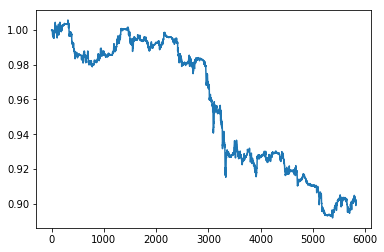

In [251]:
plt.plot(x)
x[-1]

In [115]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p,predict=True)
    newy_test = denormalize(stock_name, normalized_value_y_test,predict=False)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()